**1. Import Libraries/ Dataset**

a. Import the required libraries and the dataset (use Google Drive if required).

b. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [201]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd

import os


print(tf.__version__)

2.4.1


In [2]:
# copy dataset
!wget --no-check-certificate \
  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz \
  -O /tmp/imagenette2-160.tgz

--2021-05-23 12:12:51--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.48.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.48.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘/tmp/imagenette2-160.tgz’

/tmp/imagenette2-16 100%[===================>]  94.42M  15.8MB/s    in 7.3s    

2021-05-23 12:12:59 (13.0 MB/s) - ‘/tmp/imagenette2-160.tgz’ saved [99003388/99003388]



In [3]:
import os
import tarfile

# open file
file = tarfile.open('/tmp/imagenette2-160.tgz')
  
# extract file
file.extractall('/tmp')

#close file
file.close()

In [4]:
# set directories
base_dir = '/tmp/imagenette2-160'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

**2. Data Visualization and Augmentation**

a. Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).

b. Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

c. Bring the train and test data in the required format.

d. Print the shapes of train and test data.



In [5]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# set image and batch size
num_img_rows=75 # image height, actual=213
num_img_cols=75 # image width, actual=160
num_color_channels=3
num_batch_size=100

train_datagen = ImageDataGenerator(
                  rescale=1.0/255.0,
                  rotation_range=40,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                )

val_datagen = ImageDataGenerator(
                rescale=1.0/255.0
              )

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=num_batch_size,
                    target_size=(num_img_rows, num_img_cols),
                    class_mode='categorical'
                  )

val_generator = val_datagen.flow_from_directory(
                  val_dir,
                  batch_size=num_batch_size,
                  target_size=(num_img_rows, num_img_cols),
                  class_mode='categorical'
                )

# print shape of training data after transformation
for train_image_batch, train_labels_batch in train_generator:
  print('Training image batch shape, after transformation:', train_image_batch.shape)
  print('Training label batch shape, after transformation:', train_labels_batch.shape)
  break

# print shape of test data after transformation
for val_image_batch, val_labels_batch in val_generator:
  print('Validation image batch shape, after transformation:', val_image_batch.shape)
  print('Validation label batch shape, after transformation:', val_labels_batch.shape)
  break

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Training image batch shape, after transformation: (100, 75, 75, 3)
Training label batch shape, after transformation: (100, 10)
Validation image batch shape, after transformation: (100, 75, 75, 3)
Validation label batch shape, after transformation: (100, 10)


In [6]:
# Preparing ImageDataGenerator for augmentation

train_datagen_rotate = ImageDataGenerator(rescale=1/255, rotation_range=30, fill_mode='nearest')
train_datagen_hshift = ImageDataGenerator(rescale=1/255, height_shift_range=0.3)

hshift_train_dir = '/tmp/imagenette2-160/train_hshift'
rotate_train_dir = '/tmp/imagenette2-160/train_rotate'

## Data Augumentation... 
def apply_augmentation(train_dir, tgt_dir, img_datagen):
  print ("Applying Augmentation to Target directory :", tgt_dir)
  for i, folder_name in enumerate(os.listdir(train_dir)):
    if (folder_name != '.DS_Store'):
      hshift_folder_name = '/tmp/imagenette2-160/' + tgt_dir +'/' + folder_name
      if (os.path.exists(hshift_folder_name) == False):
        os.makedirs(hshift_folder_name)

      img_placeholder = []
      folder_name = '/tmp/imagenette2-160/train/' + folder_name + '/'
      folder_images = os.listdir(folder_name)
      print ("Processing folder: ", folder_name)

      for j, img_name in enumerate(folder_images):
        tmp_image = image.load_img(folder_name + img_name)
        x = image.img_to_array(tmp_image)  # this is a Numpy array with shape (160, 160, 3)    
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 160, 160, 3)
        # train_datagen_hflip.flow(x, batch_size=512,save_to_dir= hshift_folder_name, save_prefix=img_name,save_format="jpeg")
        k = 0
        for batch in img_datagen.flow(x, batch_size=512,save_to_dir= hshift_folder_name, save_prefix=img_name,save_format="jpeg"):
          k += 1
          # print ("in flow func | folder_name", img_name, folder_name)
          if k > 0:
            break  # otherwise the generator would loop indefinitely
      
      aug_folder_images = os.listdir(hshift_folder_name + '/')
      for k, aug_img_name in enumerate(aug_folder_images):
          new_img_name = aug_img_name.split('.')[0]
          new_img_name = new_img_name + '.jpeg'
          src = hshift_folder_name + '/' + aug_img_name
          dst = hshift_folder_name + '/' + new_img_name
          os.rename(src,dst)

def get_pics_list(train_dir, num_imgs):
  print ("Getting pictures list...")
  pic = {}
  pic_names_list = {}
  for dir in os.listdir(train_dir):
    if (dir != ".DS_Store"):
      print("processing dir :", dir)
      i = 0
      for fname in os.listdir(os.path.join(train_dir,dir)): 
        if (i < num_imgs):
          # print("processing file :", i, ":", fname)
          # pic.append(os.path.join(train_dir,dir,fname))
          pic[dir + '_'+str(i)] = os.path.join(train_dir,dir,fname)
          pic_names_list[dir + '_'+str(i)] = fname
        i += 1
  return pic_names_list 
def print_sample_imgs(pic):
  nrows = 20
  ncols = 3

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("Printing Sample image with Height shift and Rotation :")
  print("======================================================")
  j = 0
  for i, img_nm in enumerate(pic.keys()):
    just_img_nm = img_nm.split(sep='_')[0]
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, j + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm)
    # printing main img
    raw_img_nm = train_dir + '/' + just_img_nm + '/' + pic[img_nm]
    img = mpimg.imread(raw_img_nm)
    # print (raw_img_nm)
    plt.imshow(img)

    sp = plt.subplot(nrows, ncols, j + 2)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm + '(Height_Shift)')
    hshift_img_nm = hshift_train_dir + '/' + just_img_nm + '/' + pic[img_nm].split(sep='.')[0] + '.jpeg'
    aug_img = mpimg.imread(hshift_img_nm)
    # print (hshift_img_nm)
    plt.imshow(aug_img)
    
    sp = plt.subplot(nrows, ncols, j + 3)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm + '(Rotation)')
    rot_img_nm = rotate_train_dir + '/' + just_img_nm + '/' + pic[img_nm].split(sep='.')[0] + '.jpeg'
    rot_img = mpimg.imread(rot_img_nm)
    # print (rot_img_nm)
    plt.imshow(rot_img)
    
    
    j = j + 3
  plt.show()
  # plt.show()


In [16]:
pics_list = get_pics_list('/tmp/imagenette2-160/train/', 2)

processing dir : n03028079
processing dir : n01440764
processing dir : n03445777
processing dir : n03888257
processing dir : n03417042
processing dir : n03425413
processing dir : n02102040
processing dir : n03000684
processing dir : n03394916
processing dir : n02979186


Printing Sample (2) images from each Label :


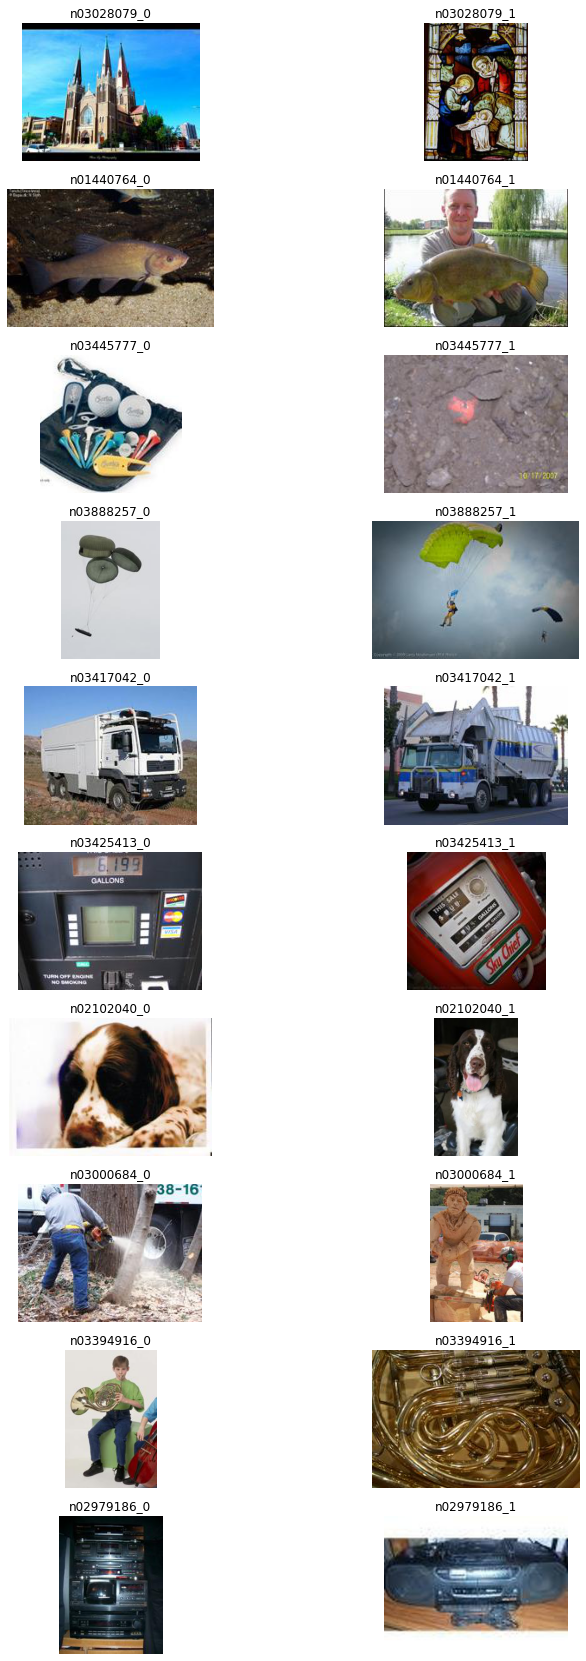

In [17]:
# Printing sample images from each target class

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 10
ncols = 2
  # Index for iterating over images
pic_index = 0 
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 6, nrows * 3)

print("============================================")
print("Printing Sample (2) images from each Label :")
print("============================================")
for i, img_path in enumerate(pics_list.keys()):
  just_img_nm = img_path.split(sep='_')[0]
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  sp.set_title(img_path)
  raw_img_nm = train_dir + '/' + just_img_nm + '/' + pics_list[img_path]
  img = mpimg.imread(raw_img_nm)
  plt.imshow(img)

plt.show()


processing dir : n03028079
processing dir : n01440764
processing dir : n03445777
processing dir : n03888257
processing dir : n03417042
processing dir : n03425413
processing dir : n02102040
processing dir : n03000684
processing dir : n03394916
processing dir : n02979186
Processing folder:  /tmp/imagenette2-160/train/n03028079/
Processing folder:  /tmp/imagenette2-160/train/n01440764/
Processing folder:  /tmp/imagenette2-160/train/n03445777/
Processing folder:  /tmp/imagenette2-160/train/n03888257/
Processing folder:  /tmp/imagenette2-160/train/n03417042/
Processing folder:  /tmp/imagenette2-160/train/n03425413/
Processing folder:  /tmp/imagenette2-160/train/n02102040/
Processing folder:  /tmp/imagenette2-160/train/n03000684/
Processing folder:  /tmp/imagenette2-160/train/n03394916/
Processing folder:  /tmp/imagenette2-160/train/n02979186/
Processing folder:  /tmp/imagenette2-160/train/n03028079/
Processing folder:  /tmp/imagenette2-160/train/n01440764/
Processing folder:  /tmp/imagenett

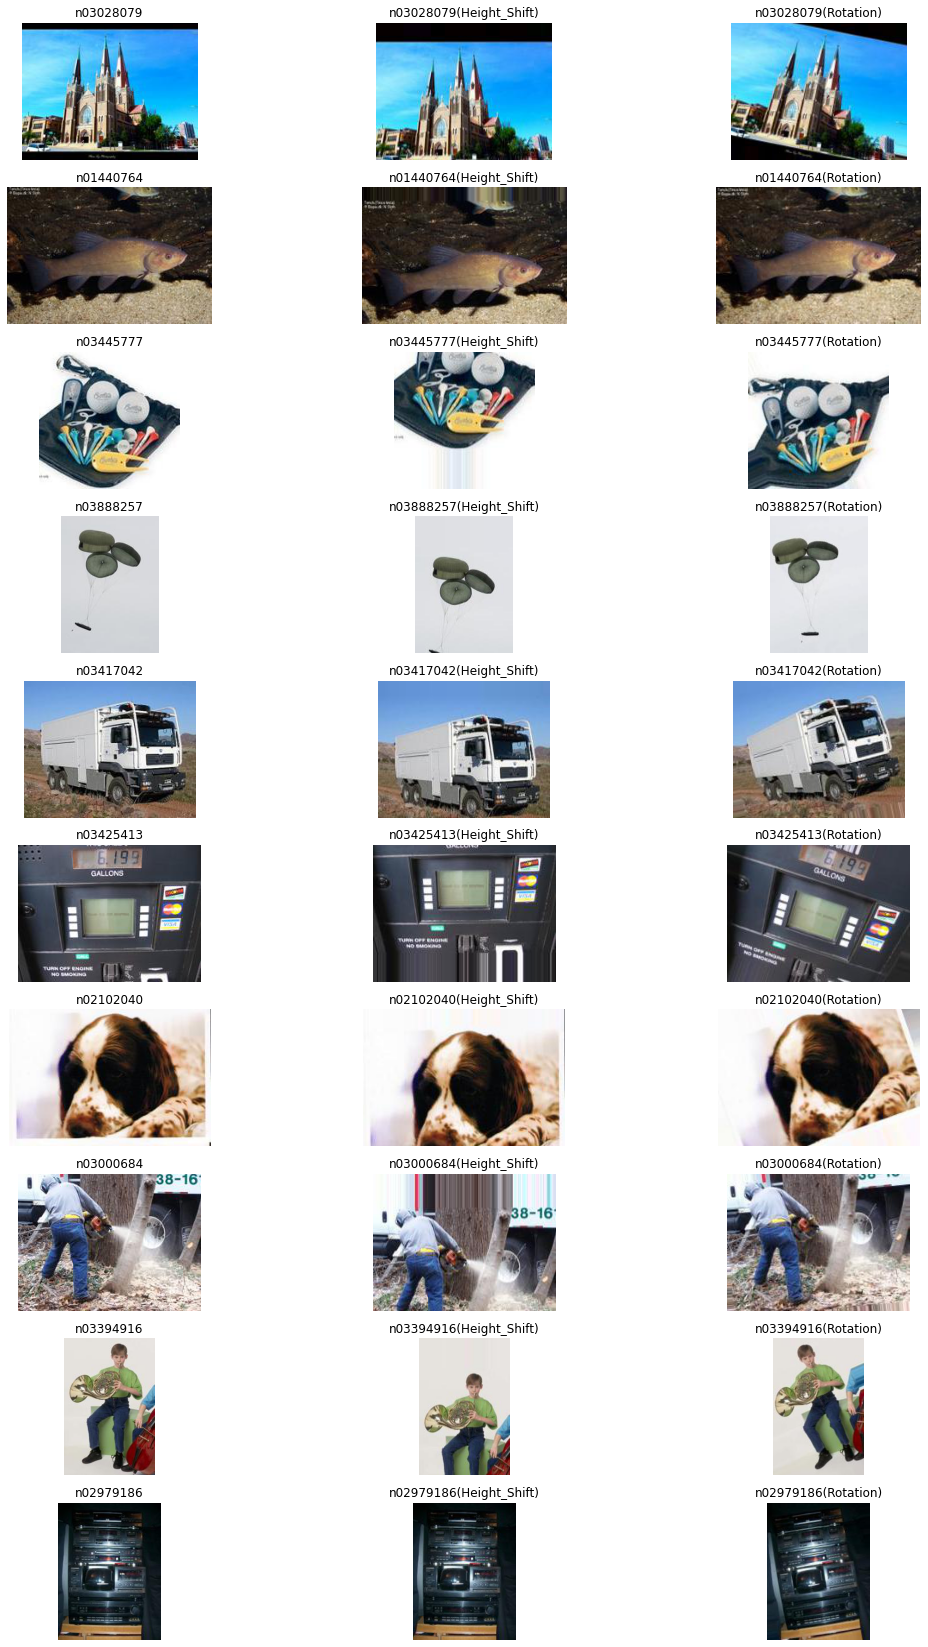

In [18]:
# Printing Augmented images

pics_list = get_pics_list('/tmp/imagenette2-160/train/', 1)

#Applying Augmentation
apply_augmentation(train_dir, "train_hshift", train_datagen_hshift)
apply_augmentation(train_dir, "train_rotate", train_datagen_rotate)

#printing Augmented images
print_sample_imgs(pics_list)

**3. Model Building**

a. Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.

d. Choose the appropriate activation function for all the layers.

e. Print the model summary.

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

# set model parameters
num_epochs=50
num_steps_per_epoch=95 # total training images/ batch size = 9465/100
num_val_steps=40 # total validation images/ batch size = 3925/100
num_dropout=0.2
num_l2_reg_penalty=0.0001
num_lr=1e-4
opt = RMSprop(lr=num_lr)
str_loss = 'categorical_crossentropy'

# build model
model = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer with regularization
          tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Add dropout
          tf.keras.layers.Dropout(num_dropout),
          # Layer 2 = hidden layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 3 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 4 = hidden layer with regularization
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 5 = output layer with regularization
          tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
        ])

**4. Model Compilation**

a. Compile the model with the appropriate loss function.

b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c. Use accuracy as a metric.

**To be done:**

Give reasons for the choice of learning rate and its value. 


In [20]:
# compile model
model.compile(loss=str_loss,
              optimizer=opt,
              metrics=['accuracy']
             )

**5. Model Training**

a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [21]:
from timeit import default_timer as timer

# timing callback class
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# timing callback
timing = TimingCallback()

# train model
history = model.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1,
            callbacks=[timing]
          )

# show model summary
model.summary()

# total training time
print('\n', 'Total time taken for training: {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

# save model
#model.save("vision.h5")

Epoch 1/50
95/95 [==============================] - 31s 299ms/step - loss: 2.7240 - accuracy: 0.1354 - val_loss: 2.5195 - val_accuracy: 0.2076
Epoch 2/50
95/95 [==============================] - 28s 299ms/step - loss: 2.4164 - accuracy: 0.2144 - val_loss: 2.2810 - val_accuracy: 0.2255
Epoch 3/50
95/95 [==============================] - 28s 299ms/step - loss: 2.2922 - accuracy: 0.2450 - val_loss: 2.1675 - val_accuracy: 0.2966
Epoch 4/50
95/95 [==============================] - 28s 299ms/step - loss: 2.1841 - accuracy: 0.2745 - val_loss: 2.0590 - val_accuracy: 0.3391
Epoch 5/50
95/95 [==============================] - 28s 299ms/step - loss: 2.1579 - accuracy: 0.2855 - val_loss: 2.0354 - val_accuracy: 0.3414
Epoch 6/50
95/95 [==============================] - 28s 291ms/step - loss: 2.1150 - accuracy: 0.3015 - val_loss: 2.0082 - val_accuracy: 0.3577
Epoch 7/50
95/95 [==============================] - 28s 292ms/step - loss: 2.0789 - accuracy: 0.3185 - val_loss: 2.0134 - val_accuracy: 0.3389

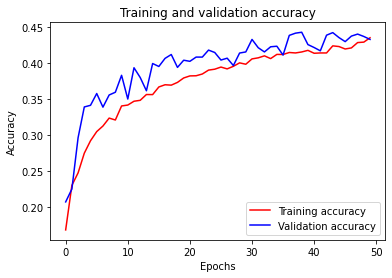

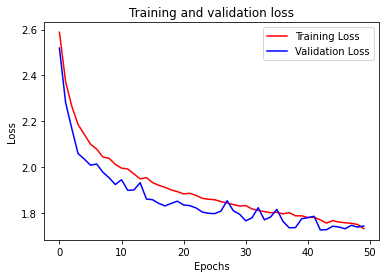

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

**6. Model Evaluation**

a. Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b. Print the two most incorrectly classified images for each class in the test dataset.

**To be done:**

Analyse and report the best and worst performing class.

Print the two most incorrectly classified images for each class in the test dataset.


In [23]:
# final training accuracy and loss
train_score = model.evaluate(train_generator)

print("Training accuracy: {:.2f}%".format(train_score[1] * 100)) 
print("Training Loss: ",train_score[0])

# final validation accuracy and loss
val_score = model.evaluate(val_generator)

print("Validation accuracy: {:.2f}%".format(val_score[1] * 100)) 
print("Validation Loss: ",val_score[0])

95/95 [==============================] - 24s 253ms/step - loss: 1.6909 - accuracy: 0.4478
Training accuracy: 44.78%
Training Loss:  1.6908926963806152
40/40 [==============================] - 4s 98ms/step - loss: 1.7430 - accuracy: 0.4326
Validation accuracy: 43.26%
Validation Loss:  1.742988109588623


In [35]:
type(target_names)

list

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# get target names
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print target_names
print('Target names:', target_names, '\n')

# Print Confusion Matrix 
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator.labels, y_pred)
print('Confusion Matrix', '\n', cm, '\n')

# Print Classification Report
print('Classification Report')
# print(classification_report(train_generator.classes, y_pred, target_names=target_names))
print(classification_report(val_generator.labels, y_pred, target_names=target_names))

Target names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257'] 

Confusion Matrix 
 [[32 40 57 13 46 59 43 23 36 38]
 [34 39 76 12 31 54 34 19 69 27]
 [29 38 59  9 49 62 30 20 41 20]
 [35 36 68 13 39 70 39 12 37 37]
 [26 41 72 18 44 52 42 23 53 38]
 [29 39 55 14 42 58 39 25 55 38]
 [33 41 65 15 45 60 34 18 54 24]
 [43 43 66 14 48 50 39 27 57 32]
 [38 36 58 12 46 68 39 19 53 30]
 [38 38 62 18 41 66 34 24 44 25]] 

Classification Report
              precision    recall  f1-score   support

   n01440764       0.09      0.08      0.09       387
   n02102040       0.10      0.10      0.10       395
   n02979186       0.09      0.17      0.12       357
   n03000684       0.09      0.03      0.05       386
   n03028079       0.10      0.11      0.10       409
   n03394916       0.10      0.15      0.12       394
   n03417042       0.09      0.09      0.09       389
   n03425413       0.13      0.06      0.09   

In [97]:
# Print the two most incorrectly classified images for each class in the test dataset.
Y_pred_proba = model.predict(val_generator)

In [239]:
predict_proba_list = []

In [240]:
for i in range(0,len(val_generator.labels)):
  # print (i, val_generator.labels[i], Y_pred_proba[i][0])
  if (val_generator.labels[i] == 0):
    # np.append(class_n01440764_proba, [val_generator.labels[i], Y_pred_proba[i][1]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][0]])
  elif (val_generator.labels[i] == 1):
    # np.append(class_n02102040_proba, [val_generator.labels[i], Y_pred_proba[i][1]], axis=0) 
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][1]])
  elif (val_generator.labels[i] == 2):
    # np.append(class_n02979186_proba, [val_generator.labels[i], Y_pred_proba[i][2]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][2]])
  elif (val_generator.labels[i] == 3):
    # np.append(class_n03000684_proba, [val_generator.labels[i], Y_pred_proba[i][3]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][3]])
  elif (val_generator.labels[i] == 4):
    # print('processing 4 class')
    # np.append(class_n03028079_proba, [val_generator.labels[i], Y_pred_proba[i][4]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][4]])
  elif (val_generator.labels[i] == 5):
    # np.append(class_n03394916_proba, [val_generator.labels[i], Y_pred_proba[i][5]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][5]])
  elif (val_generator.labels[i] == 6):
    # np.append(class_n03417042_proba, [val_generator.labels[i], Y_pred_proba[i][6]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][6]])
  elif (val_generator.labels[i] == 7):
    # np.append(class_n03425413_proba, [val_generator.labels[i], Y_pred_proba[i][7]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][7]])
  elif (val_generator.labels[i] == 8):
    # np.append(class_n03445777_proba, [val_generator.labels[i], Y_pred_proba[i][8]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][8]])
  elif (val_generator.labels[i] == 9):
    # np.append(class_n03888257_proba, [val_generator.labels[i], Y_pred_proba[i][9]], axis=0)
    predict_proba_list.append([i, val_generator.labels[i], Y_pred_proba[i][9]])


In [241]:
# print([i[1] for i in class_n03888257_proba])
df = pd.DataFrame(predict_proba_list, columns=['img_index','label','proba'])
df.tail()

,img_index,label,proba
3920,3920,9,0.042437
3921,3921,9,0.025420
3922,3922,9,0.067342
3923,3923,9,0.034591
3924,3924,9,0.016701


In [242]:
df1 = df.groupby(['label']).agg({'proba':'min'}).reset_index()
min_proba_list = df1['proba'].to_list()
# create df of min proba images
df1 = df[df['proba'].isin(min_proba_list)].copy()

In [243]:
df1

,img_index,label,proba
23,23,0,3.118999e-08
408,408,1,2.752552e-04
1111,1111,2,2.497397e-04
1314,1314,3,1.915440e-05
1720,1720,4,3.384852e-07
1972,1972,5,3.683477e-05
2519,2519,6,1.828906e-06
2898,2898,7,5.643004e-04
3235,3235,8,2.188385e-03
3713,3713,9,9.691498e-05


**Hyperparameter Tuning**

Build two more additional models by changing the following hyperparameters ONE at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

1. Network Depth: Change the number of hidden layers and hidden units for each layer

2. Regularization: Train a model without regularization

Write a comparison between each model and give reasons for the difference in results.